In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from stop_words import get_stop_words
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import string
from string import punctuation
import json
from collections import Counter
from time import time
import unicodedata
from wordcloud import WordCloud
import gensim
from gensim.models import Word2Vec
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adril\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#CARGA DE DATOS
data_dict = {}
with open('C:/Users/adril/Downloads/PracticaNLP/Video_Games_5.json', "r", encoding="utf-8") as f:
    for idx, line in enumerate(f):
        data_dict[idx] = json.loads(line)


In [3]:
#CREACIÓN DATAFRAME CON REVIEWS Y SENTIMIENTOS
reviews_text = []
reviews_sentiment = []

for review in data_dict.values():
    reviews_text.append(review.get('reviewText'))
    reviews_sentiment.append(review.get('overall'))

df_reviews = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df_reviews.dropna(subset=['review', 'sentiment'], inplace=True)
df_reviews.reset_index(drop=True, inplace=True)

In [4]:

# DESCARGA DE STOPWORDS
nltk.download('stopwords', quiet=True)
stop = set(stopwords.words('english'))

# VALORES PARA PUNTUACIÓN Y STEMMING
translator = str.maketrans('', '', string.punctuation)
stemmer = PorterStemmer()

tokens = []
for text in df_reviews['review']:
    if not text:
        continue

    lower = text.lower() # PONER EN MINUSCULAS
    
    no_punct = lower.translate(translator) # QUITAR PUNTUACION

    clean = re.sub(r'\d+', '', no_punct) # QUITAR NUMEROS

    words = clean.split() # TOKENIZAR

    filtered = [stemmer.stem(w) for w in words if w and w not in stop] # APLICACION STEMMING Y STOPWORDS

    tokens.extend(filtered)

# CARDINALIDAD DEL VOCABULARIO
vocab = set(tokens)
print("Tamaño del vocabulario:", len(vocab))

# 20 PALABRAS MÁS FRECUENTES
freq = Counter(tokens)
print("\n20 palabras más frecuentes:")
for palabra, cuenta in freq.most_common(20):
    print(f"  {palabra}: {cuenta}")

Tamaño del vocabulario: 268296

20 palabras más frecuentes:
  game: 1277845
  play: 392685
  like: 314690
  get: 270360
  one: 268178
  time: 206717
  great: 196461
  good: 189579
  use: 170254
  realli: 160895
  fun: 156466
  make: 141313
  control: 134633
  much: 132261
  also: 125040
  even: 123415
  dont: 122995
  go: 122386
  would: 121374
  charact: 121048


Distribución de reseñas por estrellas:
sentiment
1.0     30879
2.0     24133
3.0     49140
4.0     93644
5.0    299623
Name: count, dtype: int64


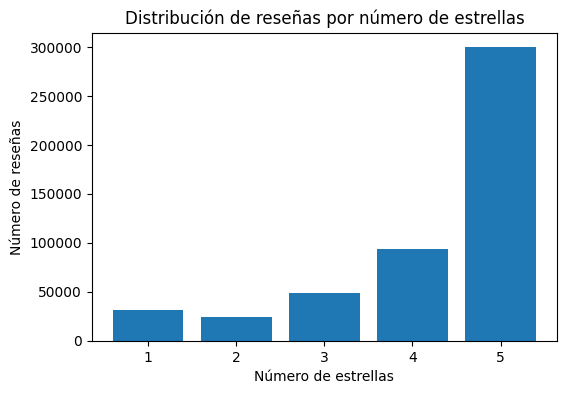

In [5]:
counts = df_reviews['sentiment'].value_counts().sort_index() # CONTAR LOS VALORES EN SENTIMIENTO

print("Distribución de reseñas por estrellas:") # MOSTRAR DISTRIBUCIÓN
print(counts)

# GRÁFICO DE LA DISTRIBUCIÓN
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(int), counts.values)
plt.xlabel('Número de estrellas')
plt.ylabel('Número de reseñas')
plt.title('Distribución de reseñas por número de estrellas')
plt.show()

In [6]:
def label_sentiment(row): # FUNCION PARA DETERMINAR POSITIVA/NEGATIVA
    if int(row['sentiment']) < 3:
        return 1 # REVIEW NEGATIVA
    else:
        return 0 # REVIEW POSITIVA
    

In [7]:
df_reviews = df_reviews.copy() # COPIA PARA EVITAR POSIBLE ERROR
df_reviews['sentiment_label'] = df_reviews.apply(lambda row: label_sentiment(row), axis=1) #APLICAR LA FUNCIÓN Y GUARDAR EN UNA NUEVA COLUMNA

Distribución:
Positivas: 442407
Negativas: 55012


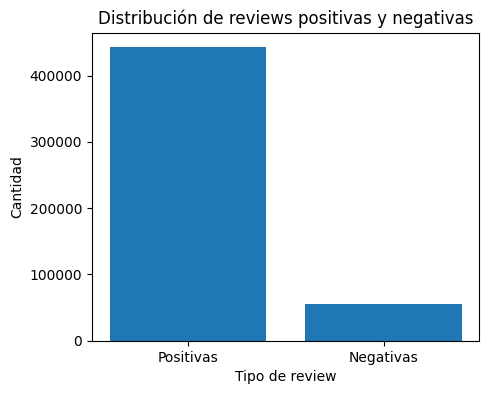

In [8]:
counts = df_reviews['sentiment_label'].value_counts().sort_index()

# DISTRIBUCIÓN REVIEWS
print("Distribución:")
print(f"Positivas: {counts[0]}")
print(f"Negativas: {counts[1]}")

# GRÁFICA
plt.figure(figsize=(5,4))
plt.bar(['Positivas', 'Negativas'], counts.values)
plt.xlabel('Tipo de review')
plt.ylabel('Cantidad')
plt.title('Distribución de reviews positivas y negativas')
plt.show()

1.4 N-GRAMS MÁS FRECUENTES

In [9]:
#BI & TRIGRAMAS

bigrams_ = ngrams(tokens, 2)
trigrams_ = ngrams(tokens, 3)

bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [10]:
bigrams_freq_.most_common(10) #BIGRAMAS

[(('play', 'game'), 48444),
 (('game', 'play'), 39065),
 (('great', 'game'), 32541),
 (('game', 'like'), 23352),
 (('feel', 'like'), 22280),
 (('video', 'game'), 20442),
 (('good', 'game'), 19667),
 (('love', 'game'), 18720),
 (('fun', 'game'), 17887),
 (('game', 'great'), 16233)]

In [11]:
trigrams_freq_.most_common(10) #TRIGRAMAS

[(('one', 'best', 'game'), 4000),
 (('first', 'person', 'shooter'), 3535),
 (('game', 'ive', 'play'), 3306),
 (('ive', 'ever', 'play'), 2905),
 (('metal', 'gear', 'solid'), 2827),
 (('game', 'ever', 'play'), 2780),
 (('grand', 'theft', 'auto'), 2672),
 (('game', 'ive', 'ever'), 2488),
 (('best', 'game', 'ever'), 2474),
 (('game', 'lot', 'fun'), 2208)]

1.5 NUBES DE PALABRAS

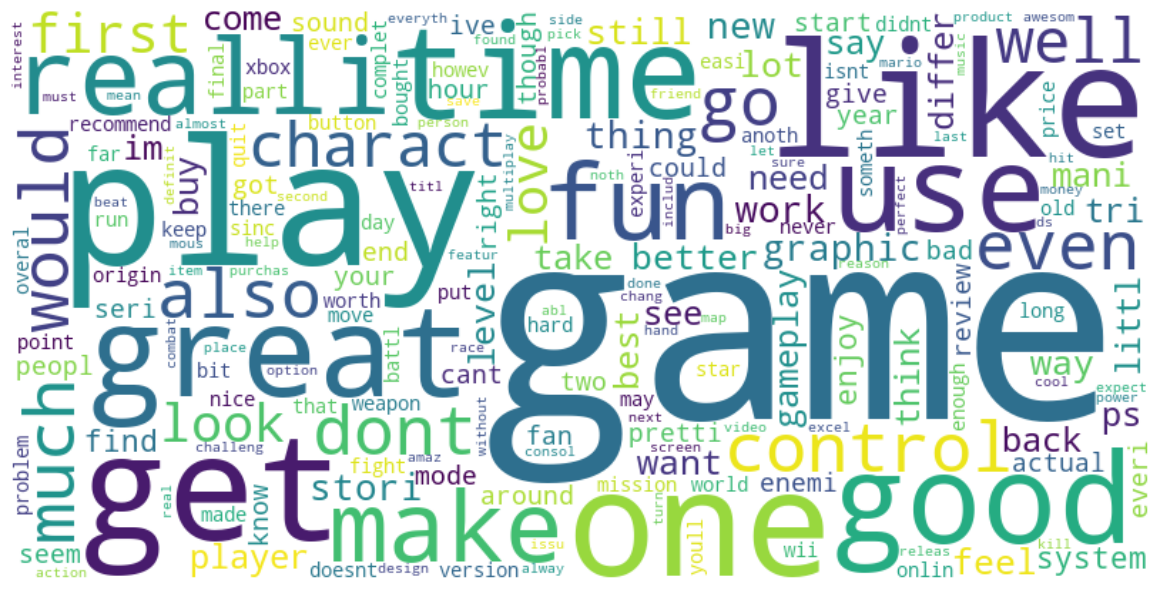

In [12]:
freq = Counter(tokens) #FRECUENCIA DE CADA PALABRA
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq) # CREAR NUBE

# GRÁFICA
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

1.6 VISUALIZACIÓN EN 2 DIMENSIONES DE ALGUNOS WORD EMBEDDINGS CALCULADOS CON WORD2VEC (ELEGIR 4-5 PALABRAS Y PINTAR LAS TOP 10 MÁS SIMILARES)

In [ ]:
stop = set(stopwords.words('english')) # LOS PUSE ARRIBA PERO REPITO POR CLARIDAD
translator2 = str.maketrans('', '', punctuation)

def clean_review(text): # FUNCIÓN PARA LIMPIAR REVIEW
    text = text.lower()
    text = text.translate(translator2)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stop]
    return ' '.join(words)

cleaned_reviews = [clean_review(review) for review in df_reviews["review"] if review] # LOOP PARA LIMPIAR REVIEW A REVIEW

In [ ]:

sentences = [row.split() for row in cleaned_reviews] # TOKENIZO ORACION
cores = multiprocessing.cpu_count()

# MODELO WORD2VEC
w2v_model = Word2Vec(min_count=5,
    window=2,
    vector_size=100,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=20,
    workers=cores-1)

# CONSTRUCCIÓN DEL VOCABULARIO
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))

# ENTRENAMIENTO DEL MODELO CON MIS FRASES (SENTENCES)
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Tiempo para entrenar el modelo: {} mins'.format(round((time() - t) / 60, 2)))


In [ ]:

# PALABRAS OBJETIVO (ESCOGÍ ESTAS PORQUE ERAN LAS MÁS RELACIONADAS CON EL TOPIC)
palabras_objetivo = ['game', 'fun', 'steam', 'player', 'price']

# PARA GUARDAR TODAS LAS PALABRAS 
palabras_visualizar = set(palabras_objetivo)

# COGER LAS 10 PALABRAS MAS SIMILARES
for palabra in palabras_objetivo:
    if palabra in w2v_model.wv:
        similares = w2v_model.wv.most_similar(palabra, topn=10)
        palabras_visualizar.update([w for w, _ in similares])

# SOLO USAR PALABRAS DEL VOCABULARIO
palabras_visualizar = [word for word in palabras_visualizar if word in w2v_model.wv]

# OBTENER VECTORES Y CONVERTIR EN ARRAY
vectores = [w2v_model.wv[word] for word in palabras_visualizar]
vectores_np = np.array(vectores)

# REDUCIR DIMENSION PARA VISUALIZACIÓN
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectores_2d = tsne.fit_transform(vectores_np)

# VISUALIZACIÓN
plt.figure(figsize=(12, 10))
for i, palabra in enumerate(palabras_visualizar):
    x, y = vectores_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, palabra, fontsize=9)

plt.title("Visualización en 2D de Word Embeddings")
plt.grid(True)
plt.show()


CONCLUSIONES

CARDINALIDAD:
    Vemos que el corpus tiene una gran riqueza léxica contando con 268296 palabras diferentes. Además muchas de estas palabras se repiten consistentemente lo cual es positivo para el entrenamiento del modelo.

DISTRIBUCIÓN DE REVIEWS:
    En este caso encontramos variedad en las diferentes valoraciones, aunque con una gran superioridad de las reviews de valoración 5. En el caso de los sentimientos ocurre algo similar, hay una gran mayoría de reviews positivas lo que puede crear confusión a la hora de valorar el modelo, ya que si acierta mucho en las positivas y falla en las negativas la accuracy será buena debido a la cantidad de reviews positivas.

N-GRAMS:
    Vemos n-gramas comunes y con sentido para el tipo de reseñas que estamos anañizando, con expresiones como great game, o con nombres propios de videojuegos como Super Mario Bros.

NUBE DE PALABRAS:
    Aquí es interesante fijarnos en como al haber más reviews positivas vemos en mayor tamaño palabras que expresan positividad como like, fun; y en pequeño otras que expresan negatividad como issue o bad.